# Coding Lecture 3

Today's goal:
- (Review) Iterations to prepare the implementation of a simple gradient descent algorithm.
- `PyTorch` autograd.

In [1]:
import torch
import math
import time
from tqdm.auto import tqdm

torch.cuda.manual_seed(42)

/home/justin/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Essential components of gradient descent

Example: linear regression. Use a cubic polynomial to fit a $f(x) :=\sin(x)$ function on $D = (-\pi, \pi)$. That is:

$$\min_{p\in \mathbb{P}^3} \|p - f\|^2_{L^2(D)} $$

Equivalently, this is approximated as

$$\min_{(a,b,c,d)\in \mathbb{R}^4 } \sum_{x\in D_h} \Delta x\, |a+bx+cx^2+dx^3 - f(x)|^2 $$

In [2]:
print(torch.linspace(0, 1, 11))

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])


In [3]:
u = torch.arange(5, dtype=torch.float)
print(u)
print(u.pow(2))
print(u**2)
print(u.pow(2).sum())

tensor([0., 1., 2., 3., 4.])
tensor([ 0.,  1.,  4.,  9., 16.])
tensor([ 0.,  1.,  4.,  9., 16.])
tensor(30.)


In [4]:
# in-place operation
v = torch.arange(10).float()
print(v)
v += 2 #in-place op v = v+2
print(v)
v /= 2 # in-place op v = v/2
print(v)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
tensor([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])
tensor([1.0000, 1.5000, 2.0000, 2.5000, 3.0000, 3.5000, 4.0000, 4.5000, 5.0000,
        5.5000])


In [5]:
for i in tqdm(range(1000)):
  time.sleep(0.002)

100%|██████████| 1000/1000 [00:02<00:00, 467.92it/s]


In [6]:
with tqdm(total=1000) as pbar:
  for i in range(1000):
    time.sleep(0.006)
    if i % 100 == 0:
      pbar.update(100)
      pbar.set_description(f"{i}-th iteration")

900-th iteration: 100%|██████████| 1000/1000 [00:06<00:00, 162.64it/s]


In [7]:
# f-string
pi = math.pi
print("Pi is approx. 3.14")
print(f"Pi is approx. {pi}")
print(f"Pi is approx. {100*pi:2.5f}")

Pi is approx. 3.14
Pi is approx. 3.141592653589793
Pi is approx. 314.15927


In [8]:
z = 0.0
for _ in range(5): # _ means None
  z += 1
print(z)

5.0


In [9]:
z = [1 for _ in range(5)]
print(z)
z = ["hello" for i in range(5)]
print(z)

[1, 1, 1, 1, 1]
['hello', 'hello', 'hello', 'hello', 'hello']


In [10]:
dtype = torch.float # single-precision float number
device = torch.device("cpu")

# Create input and output data
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
delta_x = x[1] - x[0] # (end - start)/(2000-1)
y = torch.sin(x)

# Randomly initialize weights
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-3
N_iter = 2000
with tqdm(total=N_iter) as pbar:
    for _ in range(N_iter):
        # Forward pass: compute predicted y
        y_pred = a + b * x + c * x ** 2 + d * x ** 3

        # Compute and print loss
        loss = (delta_x*(y_pred - y).pow(2).sum())

        # Backprop (chain rule) to compute gradients of a, b, c, d with respect to loss
        grad_y_pred = 2.0 * delta_x * (y_pred - y)
        grad_a = grad_y_pred.sum()
        grad_b = (grad_y_pred * x).sum()
        grad_c = (grad_y_pred * x ** 2).sum()
        grad_d = (grad_y_pred * x ** 3).sum()

        # Update weights using gradient descent
        # in-place op: params = params - lr*grad_params
        a -= learning_rate * grad_a
        b -= learning_rate * grad_b
        c -= learning_rate * grad_c
        d -= learning_rate * grad_d

        # progress bar
        pbar.set_description(f"loss: {loss.item():.6f}")
        pbar.update()
        time.sleep(2e-3)


print(f'Result: y approx = {a.item():.3f} + {b.item():.3f} x + {c.item():.3f} x^2 + {d.item():.3f} x^3')

loss: 0.027713: 100%|██████████| 2000/2000 [00:07<00:00, 280.37it/s]

Result: y approx = 0.000 + 0.857 x + -0.000 x^2 + -0.093 x^3


In [11]:
import matplotlib.pyplot as plt

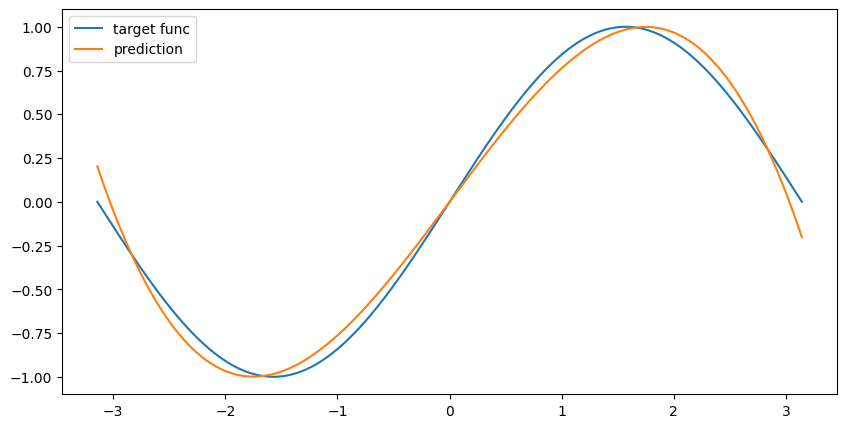

In [12]:
plt.subplots(figsize=(10, 5))
plt.plot(x, y, label="target func")
plt.plot(x, y_pred, label="prediction")
plt.legend()
plt.show()

## How to compute gradient in PyTorch: autograd

Let's take a look at how ``autograd`` collects gradients. We create two tensors ``a`` and ``b`` with
``requires_grad=True``. This signals to ``autograd`` that every operation on them should be "tracked".

Reference:
- adapted from the official tutorial

In [13]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)
c = torch.tensor([5])

In [14]:
print(a)
print(a.grad)
print(c.grad) # this is fixed in PyTorch 2.0

tensor([2., 3.], requires_grad=True)
None
None


We create another tensor ``f`` from ``a`` and ``b`` elementwisely.

\begin{align}f = 3a^3 - b^2\end{align}

or let $f = (f_i)^{\top}$ and for each $i$

\begin{align}f_i = 3a_i^3 - b_i^2\end{align}

In [15]:
f = 3*a**3 - b**2

print(f)

tensor([-12.,  65.], grad_fn=<SubBackward0>)


``a`` and ``b`` are usually parameters of a neural network, and ``f``
to be the ``loss function`` (similar to the error/residual above). In gradient based methods, we want gradients of each component of $f$ w.r.t. parameters, i.e.

\begin{align}\frac{\partial f_i}{\partial a_i} = 9a_i^2\end{align}

\begin{align}\frac{\partial f_i}{\partial b_i} = -2b_i\end{align}


When we call ``.backward()`` on ``f``, autograd calculates these gradients
and stores them in the respective tensors' ``.grad`` attribute.

We need to explicitly pass a ``gradient`` argument in ``f.backward()`` because it is a vector.
``gradient`` is a tensor of the same shape as ``f``, and it represents the
gradient of $f$ w.r.t. itself, i.e.

\begin{align}\frac{df_i}{df_i} = 1\end{align}

Equivalently, we can also aggregate $f$ into a scalar and call backward implicitly, like ``f.sum().backward()``.

In [16]:
external_grad = torch.tensor([1., 1.])
# first component and second component modifier
f.backward(gradient=external_grad)

Gradients are now deposited in ``a.grad`` and ``b.grad``


In [17]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)
print(torch.allclose(-2*b, b.grad))
print(a.grad)
print(b.grad)

tensor([True, True])
tensor([True, True])
True
tensor([36., 81.])
tensor([-12.,  -8.])


In [18]:
a.grad = None
b.grad = None

Now set $g = \sum f_i$

In [19]:
g = (3*a**3 - b**2).sum()

In [20]:
g.backward()

In [21]:
print(a.grad)
print(b.grad)

tensor([36., 81.])
tensor([-12.,  -8.])


## Implementation of GD using autograd



In [22]:
# Create input and output data
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
delta_x = x[1] - x[0]
y = torch.sin(x)

# Randomly initialize weights
a = torch.randn((),
                device=device,
                dtype=dtype,
                requires_grad=True)
b = torch.randn((),
                device=device,
                dtype=dtype,
                requires_grad=True)
c = torch.randn((),
                device=device,
                dtype=dtype,
                requires_grad=True)
d = torch.randn((),
                device=device,
                dtype=dtype,
                requires_grad=True)

learning_rate = 1e-3
N_iter = 2000
with tqdm(total=N_iter) as pbar:
    for t in range(N_iter):
        # Forward pass: compute predicted y
        y_pred = a + b * x + c * x ** 2 + d * x ** 3
        # for p in [a, b, c, d]:
        #     p.grad = None

        # Compute and print loss
        loss = (delta_x*(y_pred - y).pow(2).sum())

        # Backprop (chain rule) through autograd
        loss.backward()

        # Update weights using gradient descent
        with torch.no_grad():
          # this is necessary if autograd attribute
          # is called manually
            a -= learning_rate * a.grad
            b -= learning_rate * b.grad
            c -= learning_rate * c.grad
            d -= learning_rate * d.grad

            # manually zeroing the grad stored in each variable
            a.grad.zero_() # zero_ means in-place version of zero
            b.grad.zero_() # b.grad = 0
            c.grad.zero_()
            d.grad.zero_()

        pbar.set_description(f"loss: {loss.item():.6f}")
        pbar.update()
        time.sleep(2e-3)


print(f'Result: y approx = {a.item():.3f} + {b.item():.3f} x + {c.item():.3f} x^2 + {d.item():.3f} x^3')

loss: 0.027713: 100%|██████████| 2000/2000 [00:08<00:00, 244.79it/s]


Result: y approx = -0.000 + 0.857 x + 0.000 x^2 + -0.093 x^3


## Implementation using matmul

Data matrix $X$:

$$
X_{i, \cdot}  = [1, x_i, x_i^2, x_i^3 ], y_i = f(x_i), \text{ and } w = [a, b, c, d]^{\top}
$$
then the regression becomes
$$
\min_{w\in \mathbb{R}^4}\Delta x\, \|Xw - y\|^2
$$


In [23]:
print(x.shape)
X = torch.stack([x**0, x**1, x**2, x**3], dim=-1)
print(X.shape)

torch.Size([2000])
torch.Size([2000, 4])


In [24]:
# code here

# Create input and output data
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
delta_x = x[1] - x[0]
y = torch.sin(x)

# Randomly initialize weights
w = torch.randn((4, 1),
                device=device,
                dtype=dtype,
                requires_grad=True)

# data matrix
X = torch.stack([x**0, x**1, x**2, x**3], dim=-1)

learning_rate = 1e-3
N_iter = 2000
with tqdm(total=N_iter) as pbar:
    for t in range(N_iter):
        # Forward pass: compute predicted y
        y_pred = X.mm(w)
        # y_pred has shape (2000, 1) while y has (2000)
        # y_pred - y then yields a (2000, 2000) tensor
        # because y is broadcasted to match the shape of y_pred
        # the following line of code fixes this
        y_pred = y_pred.reshape(-1)

        # Compute and print loss
        loss = (delta_x*(y_pred - y).pow(2).sum())

        # Backprop (chain rule) through autograd
        loss.backward()

        # Update weights using gradient descent
        with torch.no_grad():
          # this is necessary if autograd attribute
          # is called manually
            w -= learning_rate * w.grad

            # manually zeroing the grad stored in each variable
            w.grad.zero_() # zero_ means in-place version of zero

        pbar.set_description(f"loss: {loss.item():.6f}")
        pbar.update()
        time.sleep(2e-3)


print(f'Result: y approx = {w[0].item():.3f} + {w[1].item():.3f} x + {w[2].item():.3f} x^2 + {w[3].item():.3f} x^3')

loss: 9.000370:   1%|          | 14/2000 [00:00<00:06, 301.98it/s] 

loss: 0.027713: 100%|██████████| 2000/2000 [00:08<00:00, 247.83it/s]


Result: y approx = -0.000 + 0.857 x + 0.000 x^2 + -0.093 x^3
